# Project  :  Wheather prediction using LSTM and GRU in Islamabad Pakistan

## 1. Adding libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
import requests


## 2 Fetch Islamabad Weather Data (3 Features)

In [ ]:
latitude = 33.6844
longitude = 73.0479
url = (
    "https://api.open-meteo.com/v1/forecast?"
    f"latitude={latitude}&longitude={longitude}"
    "&hourly=temperature_2m,relative_humidity_2m,precipitation"
    "&past_days=90"
)
response = requests.get(url)
data = response.json()
df = pd.DataFrame({
    "time": pd.to_datetime(data["hourly"]["time"]),
    "temperature": data["hourly"]["temperature_2m"],
    "humidity": data["hourly"]["relative_humidity_2m"],
    "precipitation": data["hourly"]["precipitation"]
})
df.head()


,time,temperature,humidity,precipitation
0,2025-09-19 00:00:00,NaN,NaN,NaN
1,2025-09-19 01:00:00,NaN,NaN,NaN
2,2025-09-19 02:00:00,NaN,NaN,NaN
3,2025-09-19 03:00:00,NaN,NaN,NaN
4,2025-09-19 04:00:00,NaN,NaN,NaN


In [ ]:

print("Missing values before cleaning:")
print(df.isnull().sum())
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)
df.drop_duplicates(inplace=True)
print("\nMissing values after cleaning:")
print(df.isnull().sum())
df.head()

Missing values before cleaning:
time               0
temperature      296
humidity         296
precipitation    296
dtype: int64

Missing values after cleaning:
time             0
temperature      0
humidity         0
precipitation    0
dtype: int64


/tmp/ipython-input-644578372.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipython-input-644578372.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


,time,temperature,humidity,precipitation
0,2025-09-19 00:00:00,33.4,33.0,0.0
1,2025-09-19 01:00:00,33.4,33.0,0.0
2,2025-09-19 02:00:00,33.4,33.0,0.0
3,2025-09-19 03:00:00,33.4,33.0,0.0
4,2025-09-19 04:00:00,33.4,33.0,0.0


## 3  Raw Data Visualization (EDA)

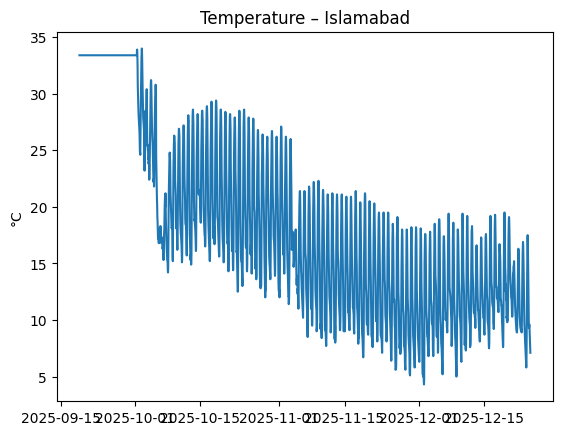

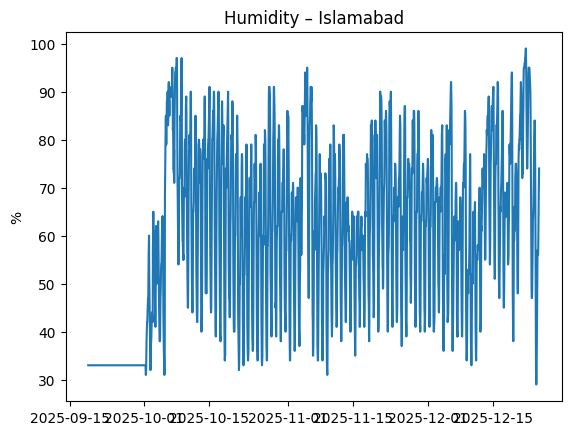

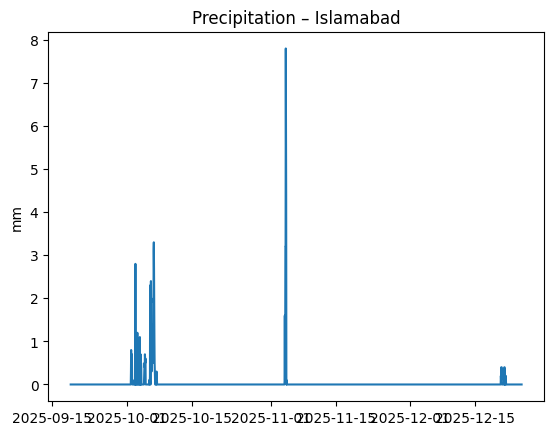

In [ ]:
plt.figure()
plt.plot(df["time"], df["temperature"])
plt.title("Temperature – Islamabad")
plt.ylabel("°C")
plt.show()

plt.figure()
plt.plot(df["time"], df["humidity"])
plt.title("Humidity – Islamabad")
plt.ylabel("%")
plt.show()

plt.figure()
plt.plot(df["time"], df["precipitation"])
plt.title("Precipitation – Islamabad")
plt.ylabel("mm")
plt.show()


## 4 — Normalize All Features

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(
    df[["temperature", "humidity", "precipitation"]]
)

## 5 Create Multivariate Sequences

Past 24 hours → Next 24 hours (ALL variables)

In [ ]:
def create_sequences(data, lookback=24, horizon=24):
    X, y = [], []
    for i in range(len(data) - lookback - horizon):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
X_train.shape, y_train.shape

((1824, 24, 3), (1824, 24, 3))

## 6 — LSTM Model (Multivariate, 24×3 Output)

In [ ]:
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(24, 3)),
    Dropout(0.2),
    LSTM(32),
    Dense(24 * 3)
])
lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 72)             │         2,376 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,200 (125.78 KB)

 Trainable params: 32,200 (125.78 KB)

 Non-trainable params: 0 (0.00 B)

## 7  Train LSTM

In [ ]:
history_lstm = lstm_model.fit(
    X_train,
    y_train.reshape(y_train.shape[0], -1),
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.1345 - val_loss: 0.0276
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0263 - val_loss: 0.0193
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0191 - val_loss: 0.0163
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0148 - val_loss: 0.0109
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0111 - val_loss: 0.0074
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0083 - val_loss: 0.0060
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0083 - val_loss: 0.0057
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0084 - val_loss: 0.0054
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0078 - val_loss: 0.0052
Epoch 10/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0076 - val_loss: 0.0051
Epoch 11/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 12/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0

## 8   GRU Model

In [ ]:
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(24, 3)),
    Dropout(0.2),
    GRU(32),
    Dense(24 * 3)
])
gru_model.compile(optimizer="adam", loss="mse")
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 64)         │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 72)             │         2,376 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,032 (97.78 KB)

 Trainable params: 25,032 (97.78 KB)

 Non-trainable params: 0 (0.00 B)

## 9  Train GRU

In [ ]:
history_gru = gru_model.fit(
    X_train,
    y_train.reshape(y_train.shape[0], -1),
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.1403 - val_loss: 0.0318
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0293 - val_loss: 0.0198
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0201 - val_loss: 0.0174
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0183 - val_loss: 0.0146
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0148 - val_loss: 0.0103
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0119 - val_loss: 0.0073
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0095 - val_loss: 0.0061
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0082 - val_loss: 0.0058
Epoch 10/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0081 - val_loss: 0.0058
Epoch 11/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 12/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0

## 10 Loss vs Epoch (LSTM)

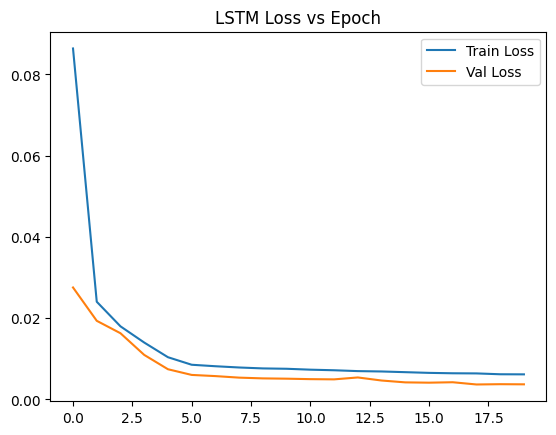

In [ ]:
plt.figure()
plt.plot(history_lstm.history["loss"], label="Train Loss")
plt.plot(history_lstm.history["val_loss"], label="Val Loss")
plt.title("LSTM Loss vs Epoch")
plt.legend()
plt.show()

## 11 Loss vs Epoch (GRU)

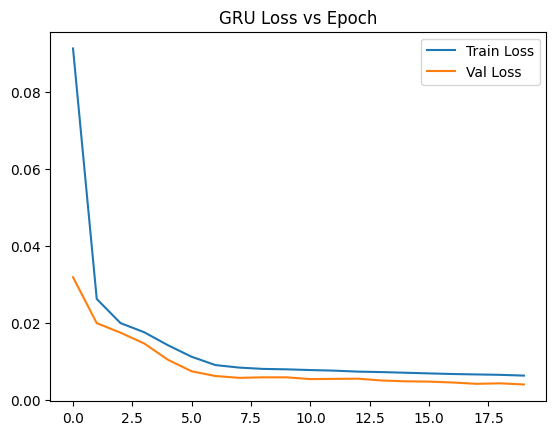

In [ ]:
plt.figure()
plt.plot(history_gru.history["loss"], label="Train Loss")
plt.plot(history_gru.history["val_loss"], label="Val Loss")
plt.title("GRU Loss vs Epoch")
plt.legend()
plt.show()


## 12 Save Models

In [ ]:
lstm_model.save("islamabad_lstm_weather_24h.h5")
gru_model.save("islamabad_gru_weather_24h.h5")
print("Models saved successfully")

Models saved successfully


## 13 Predict NEXT 24 HOURS (DEMO CELL )

In [ ]:
last_24 = data_scaled[-24:].reshape(1, 24, 3)

lstm_future = lstm_model.predict(last_24).reshape(24, 3)
gru_future = gru_model.predict(last_24).reshape(24, 3)

lstm_future_inv = scaler.inverse_transform(lstm_future)
gru_future_inv = scaler.inverse_transform(gru_future)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


## 14 — NEXT DAY FORECAST PLOTS (ALL VARIABLES)

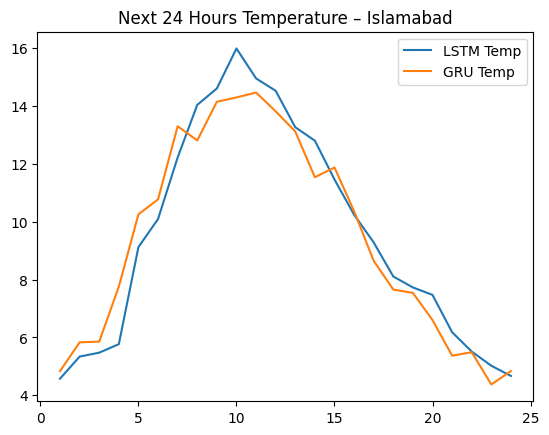

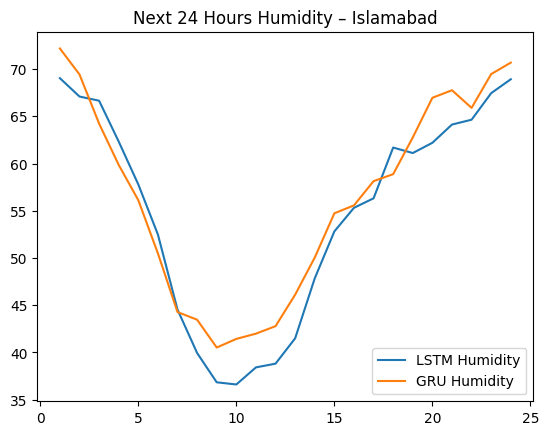

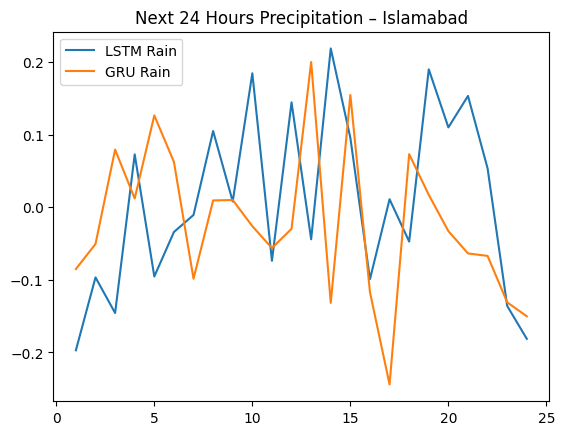

In [ ]:
hours = np.arange(1, 25)
plt.figure()
plt.plot(hours, lstm_future_inv[:,0], label="LSTM Temp")
plt.plot(hours, gru_future_inv[:,0], label="GRU Temp")
plt.title("Next 24 Hours Temperature – Islamabad")
plt.legend()
plt.show()
plt.figure()
plt.plot(hours, lstm_future_inv[:,1], label="LSTM Humidity")
plt.plot(hours, gru_future_inv[:,1], label="GRU Humidity")
plt.title("Next 24 Hours Humidity – Islamabad")
plt.legend()
plt.show()
plt.figure()
plt.plot(hours, lstm_future_inv[:,2], label="LSTM Rain")
plt.plot(hours, gru_future_inv[:,2], label="GRU Rain")
plt.title("Next 24 Hours Precipitation – Islamabad")
plt.legend()
plt.show()

##  15 ACTUAL vs LSTM vs GRU (24 HOURS ONLY)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


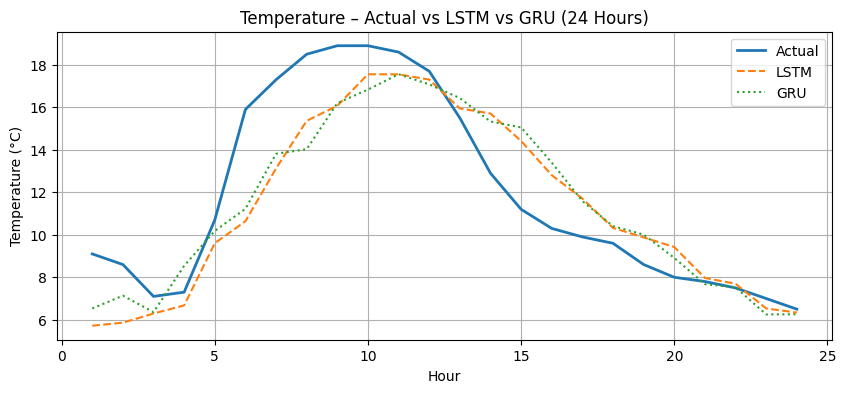

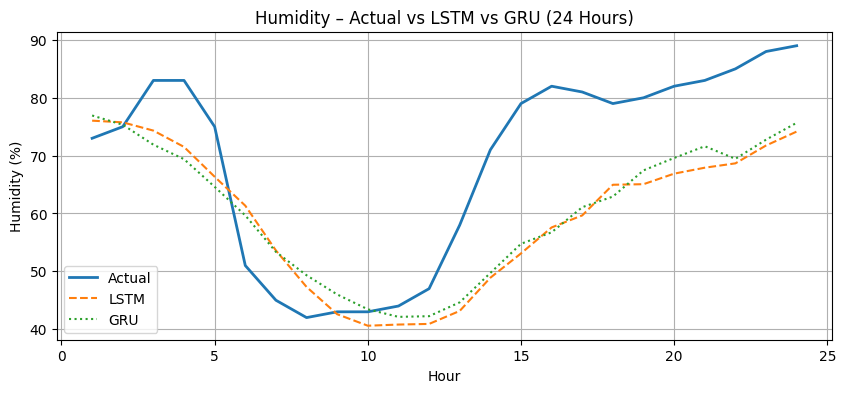

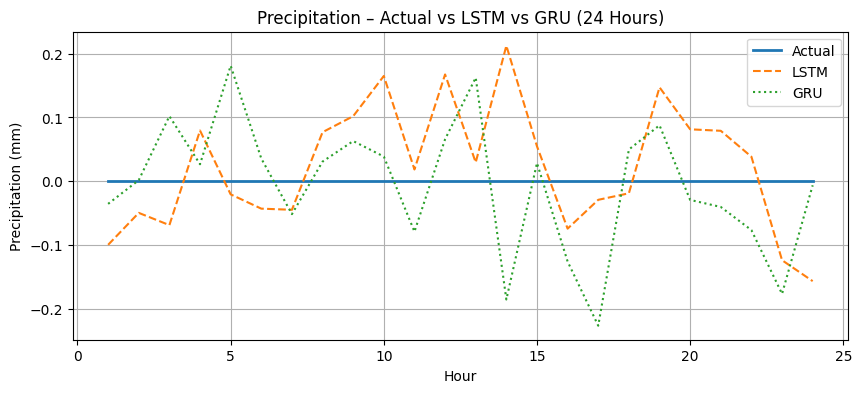

In [ ]:
lstm_test_pred = lstm_model.predict(X_test)
gru_test_pred = gru_model.predict(X_test)
sample_idx = 0
y_actual_24 = y_test[sample_idx].reshape(24, 3)
lstm_pred_24 = lstm_test_pred[sample_idx].reshape(24, 3)
gru_pred_24 = gru_test_pred[sample_idx].reshape(24, 3)
y_actual_24_inv = scaler.inverse_transform(y_actual_24)
lstm_pred_24_inv = scaler.inverse_transform(lstm_pred_24)
gru_pred_24_inv = scaler.inverse_transform(gru_pred_24)
hours = np.arange(1, 25)
plt.figure(figsize=(10,4))
plt.plot(hours, y_actual_24_inv[:,0], label="Actual", linewidth=2)
plt.plot(hours, lstm_pred_24_inv[:,0], label="LSTM", linestyle="--")
plt.plot(hours, gru_pred_24_inv[:,0], label="GRU", linestyle=":")
plt.title("Temperature – Actual vs LSTM vs GRU (24 Hours)")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,4))
plt.plot(hours, y_actual_24_inv[:,1], label="Actual", linewidth=2)
plt.plot(hours, lstm_pred_24_inv[:,1], label="LSTM", linestyle="--")
plt.plot(hours, gru_pred_24_inv[:,1], label="GRU", linestyle=":")
plt.title("Humidity – Actual vs LSTM vs GRU (24 Hours)")
plt.xlabel("Hour")
plt.ylabel("Humidity (%)")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,4))
plt.plot(hours, y_actual_24_inv[:,2], label="Actual", linewidth=2)
plt.plot(hours, lstm_pred_24_inv[:,2], label="LSTM", linestyle="--")
plt.plot(hours, gru_pred_24_inv[:,2], label="GRU", linestyle=":")
plt.title("Precipitation – Actual vs LSTM vs GRU (24 Hours)")
plt.xlabel("Hour")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.grid(True)
plt.show()


##  16  NUMERICAL NEXT 24 HOURS WEATHER PREDICTION

In [ ]:
hours = np.arange(1, 25)
print("\nNEXT 24 HOURS WEATHER PREDICTION – ISLAMABAD\n")
print("Hour | LSTM Temp(°C) | GRU Temp(°C) | LSTM Hum(%) | GRU Hum(%) | LSTM Rain(mm) | GRU Rain(mm)")
print("-" * 95)
for h in range(24):
    print(
        f"{h+1:02d}   | "
        f"{lstm_future_inv[h,0]:6.2f}        | {gru_future_inv[h,0]:6.2f}        | "
        f"{lstm_future_inv[h,1]:6.2f}        | {gru_future_inv[h,1]:6.2f}        | "
        f"{lstm_future_inv[h,2]:6.2f}         | {gru_future_inv[h,2]:6.2f}"
    )


NEXT 24 HOURS WEATHER PREDICTION – ISLAMABAD

Hour | LSTM Temp(°C) | GRU Temp(°C) | LSTM Hum(%) | GRU Hum(%) | LSTM Rain(mm) | GRU Rain(mm)
-----------------------------------------------------------------------------------------------
01   |   4.58        |   4.84        |  69.04        |  72.19        |  -0.20         |  -0.09
02   |   5.34        |   5.83        |  67.10        |  69.44        |  -0.10         |  -0.05
03   |   5.47        |   5.86        |  66.66        |  64.23        |  -0.15         |   0.08
04   |   5.77        |   7.76        |  62.33        |  59.86        |   0.07         |   0.01
05   |   9.12        |  10.25        |  57.78        |  56.12        |  -0.10         |   0.13
06   |  10.09        |  10.77        |  52.48        |  50.48        |  -0.03         |   0.06
07   |  12.21        |  13.30        |  44.53        |  44.27        |  -0.01         |  -0.10
08   |  14.03        |  12.80        |  39.93        |  43.46        |   0.10         |   0.01
09 

##  17  Next Day summary

In [ ]:
print("\nNext Day Summary (LSTM):")
print(f"Avg Temp: {lstm_future_inv[:,0].mean():.2f} °C")
print(f"Max Temp: {lstm_future_inv[:,0].max():.2f} °C")
print(f"Total Rain: {lstm_future_inv[:,2].sum():.2f} mm")



Next Day Summary (LSTM):
Avg Temp: 9.52 °C
Max Temp: 15.98 °C
Total Rain: 0.19 mm
